In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
# Load the full MNIST dataset
full_trainset = datasets.MNIST('full_trainset', download=True, train=True, transform=transform)

# Splitting full_trainset into trainset, valset, and testset
train_size = int(0.8 * len(full_trainset))
val_size = int(0.1 * len(full_trainset))
test_size = len(full_trainset) - (train_size + val_size)

trainset, valset, testset = torch.utils.data.random_split(full_trainset, [train_size, val_size, test_size])

# Create data loaders for trainset, valset, and testset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)  
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:17<00:00, 573208.24it/s] 


Extracting full_trainset\MNIST\raw\train-images-idx3-ubyte.gz to full_trainset\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 96939.03it/s]


Extracting full_trainset\MNIST\raw\train-labels-idx1-ubyte.gz to full_trainset\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 858131.74it/s]


Extracting full_trainset\MNIST\raw\t10k-images-idx3-ubyte.gz to full_trainset\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1627276.74it/s]


Extracting full_trainset\MNIST\raw\t10k-labels-idx1-ubyte.gz to full_trainset\MNIST\raw



In [4]:
#limited processing - therefore processing in batches
dataiter = iter(trainloader)

images, labels  = next(dataiter)

#printing dimensions of the arrays
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [5]:
#Neural network architecture
input_size = 784 
#why 784? 28*28 is dim of img
hidden_sizes = [128, 64] #creating two hidden layer of 128 and 64 neurons each
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [6]:
#Backward propogation
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculates the NLL loss
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [ 0.0065,  0.0065,  0.0065,  ...,  0.0065,  0.0065,  0.0065],
        ...,
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [ 0.0024,  0.0024,  0.0024,  ...,  0.0024,  0.0024,  0.0024],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002]])


In [7]:
# Training and Validation
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

# Initialize lists to store metrics
losses = []
accuracies = []
val_losses = []
val_accuracies = []

time0 = time()
epochs = 30

for e in range(epochs):
    running_loss = 0
    correct_count = 0

    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy for this batch
        _, predicted = torch.max(output.data, 1)
        correct_count += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for this epoch
    avg_loss = running_loss / len(trainloader)
    accuracy = correct_count / len(trainloader.dataset)

    # Append loss and accuracy to lists
    losses.append(avg_loss)
    accuracies.append(accuracy)

    # Print epoch results for training
    print(f"Epoch {e+1}/{epochs} - Training loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.4f}")

    # Validation loop
    model.eval()  # Set the model to evaluation mode

    val_loss = 0
    val_correct_count = 0

    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(images.shape[0], -1)
            output = model(images)
            val_loss += criterion(output, labels).item()

            # Calculate accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            val_correct_count += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(valloader)
    val_accuracy = val_correct_count / len(valloader.dataset)

    # Append validation metrics to lists
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch results for validation
    print(f"Epoch {e+1}/{epochs} - Validation loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/30 - Training loss: 0.7032, Training Accuracy: 0.7999
Epoch 1/30 - Validation loss: 0.3428, Validation Accuracy: 0.8960
Epoch 2/30 - Training loss: 0.3049, Training Accuracy: 0.9094
Epoch 2/30 - Validation loss: 0.2842, Validation Accuracy: 0.9162
Epoch 3/30 - Training loss: 0.2488, Training Accuracy: 0.9250
Epoch 3/30 - Validation loss: 0.2348, Validation Accuracy: 0.9297
Epoch 4/30 - Training loss: 0.2079, Training Accuracy: 0.9382
Epoch 4/30 - Validation loss: 0.2225, Validation Accuracy: 0.9335
Epoch 5/30 - Training loss: 0.1778, Training Accuracy: 0.9471
Epoch 5/30 - Validation loss: 0.1987, Validation Accuracy: 0.9415
Epoch 6/30 - Training loss: 0.1533, Training Accuracy: 0.9539
Epoch 6/30 - Validation loss: 0.1690, Validation Accuracy: 0.9503
Epoch 7/30 - Training loss: 0.1348, Training Accuracy: 0.9596
Epoch 7/30 - Validation loss: 0.1541, Validation Accuracy: 0.9527
Epoch 8/30 - Training loss: 0.1189, Training Accuracy: 0.9648
Epoch 8/30 - Validation loss: 0.1460, Vali

In [9]:
torch.save(model, './recog-30.pt')

In [10]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [12]:
model = torch.load("recog-30.pt")
model.eval()

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

Predicted Digit = 0


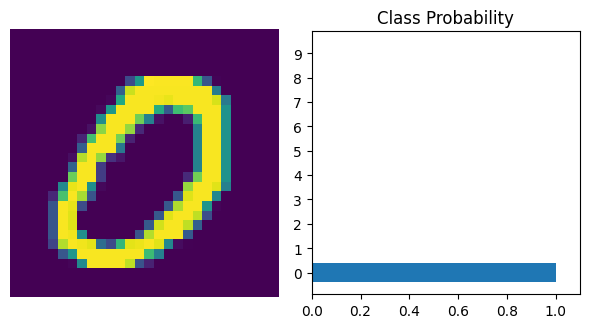

In [14]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)